<a href="https://colab.research.google.com/github/charitylefosa/python-challenge/blob/main/Project_AI_and_Data_science_Copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**AI AND DATA SCIENCE BOOTCAMP FOR WOMAN IN SA PROJECT**

**TOPIC:** Predictive Maintenance for Industrial Equipment: Build a predictive maintenance model using machine learning algorithms to predict when industrial equipment is likely to fail, enabling proactive maintenance and reducing downtime.

**EQUIPMENT OF FOCUS** Railway equipment





**how about i look into movement of the rails on maps in SA, when ever theres is over 5cm of movement it should pick that as a place that needs to be maintained**


**steps 1**
have my model load the current SA rails as they appear on maps

**step 2**
identify anything that could be identify noises( rail changes, their times, their directions and their speed)

**step 3**
have the model identify any movement that happens on the rails themself without and record the times, and take pictures or vids of when the movements happen

**step 4**
model to bip when this happens

type of sensors needed are position sensors


**data from https://www.kaggle.com/datasets/pattinson9999/uci-metropt-3-dataset?select=Metro.csv**

The dataset consists of 15169480 data points collected at 1Hz from February to August 2020 and is described by 15 features from 7 analogue (1-7) and 8 digital (8-15) sensors:

**TP2 (bar)** – the measure of the pressure on the compressor.

**TP3 (bar)** – the measure of the pressure generated at the pneumatic panel.

**H1 (bar)** – the measure of the pressure generated due to pressure drop when the discharge of the cyclonic separator filter occurs.

**DV pressure (bar)** – the measure of the pressure drop generated when the towers discharge air dryers; a zero reading indicates that the compressor is operating under load.

**Reservoirs (bar)** – the measure of the downstream pressure of the reservoirs, which should be close to the pneumatic panel pressure (TP3).

**Motor Current (A)** – the measure of the current of one phase of the three-phase motor; it presents values close to 0A - when it turns off, 4A - when working offloaded, 7A - when working under load, and 9A - when it starts working.

**Oil Temperature (ºC)** – the measure of the oil temperature on the compressor.

**COMP** - the electrical signal of the air intake valve on the compressor; it is active when there is no air intake, indicating that the compressor is either turned off or operating in an offloaded state.

**DV electric** – the electrical signal that controls the compressor outlet valve; it is active when the compressor is functioning under load and inactive when the compressor is either off or operating in an offloaded state.

**TOWERS** – the electrical signal that defines the tower responsible for drying the air and the tower responsible for draining the humidity removed from the air; when not active, it indicates that tower one is functioning; when active, it indicates that tower two is in operation.

**MPG** – the electrical signal responsible for starting the compressor under load by activating the intake valve when the pressure in the air production unit (APU) falls below 8.2 bar; it activates the COMP sensor, which assumes the same behaviour as the MPG sensor.

**LPS** – the electrical signal that detects and activates when the pressure drops below 7 bars.

**Pressure Switch** - the electrical signal that detects the discharge in the air-drying towers.

**Oil Level** – the electrical signal that detects the oil level on the compressor; it is active when the oil is below the expected values.

**Caudal Impulse** – the electrical signal that counts the pulse outputs generated by the absolute amount of air flowing from the APU to the reservoirs.

In [1]:
import numpy as np
import pandas as pd
import csv
import json
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from sklearn.impute import SimpleImputer


In [2]:
import os
print(os.listdir())

['.config', 'sample_data']


In [4]:
metro_data = pd.read_csv("metro.csv", index_col=0) # get my metro data and read first column as just index
pd.set_option('display.max_columns', None) # no specific columns set to be shown
df = pd.DataFrame(metro_data) # creating dataframe

#convert date from object(string) to date.time and handling errors if Not(Not a time stamp)
# convert to minutes to 2 decimal places
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

epoch = pd.to_datetime('2020-01-01')
#df['timestamp_seconds'] = (df['timestamp'] - epoch).dt.total_seconds()
# df['timestamp_minutes'] = df['timestamp_seconds'] / 60
# df['minutes'] = df['timestamp_minutes'].round(2)

df['hours'] = (df['timestamp'] - epoch).dt.total_seconds() / 3600

# Calculate the number of days since the epoch
# df['days'] = (df['timestamp'] - epoch).dt.days

#data processing
df = df.drop('timestamp', axis=1) # remove the timestamp
# df = df.drop('timestamp_seconds', axis=1) # remove the timestamp_seconds
# df = df.drop('timestamp_minutes', axis=1) # remove the timestamp_minutes
#df = df.drop('MPG', axis=1)
#df = df.drop('LPS', axis=1)

# Want to use only first 100 rows for my model
df = df.drop(df.index[100:])
print(df.head())


      TP2    TP3     H1  DV_pressure  Reservoirs  Oil_temperature  \
0  -0.012  9.358  9.340       -0.024       9.358           53.600   
10 -0.014  9.348  9.332       -0.022       9.348           53.675   
20 -0.012  9.338  9.322       -0.022       9.338           53.600   
30 -0.012  9.328  9.312       -0.022       9.328           53.425   
40 -0.012  9.318  9.302       -0.022       9.318           53.475   

    Motor_current  COMP  DV_eletric  Towers  MPG  LPS  Pressure_switch  \
0          0.0400   1.0         0.0     1.0  1.0  0.0              1.0   
10         0.0400   1.0         0.0     1.0  1.0  0.0              1.0   
20         0.0425   1.0         0.0     1.0  1.0  0.0              1.0   
30         0.0400   1.0         0.0     1.0  1.0  0.0              1.0   
40         0.0400   1.0         0.0     1.0  1.0  0.0              1.0   

    Oil_level  Caudal_impulses       hours  
0         1.0              1.0  744.000000  
10        1.0              1.0  744.002778  
20   

In [5]:
print(df.info())
print(df.max())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 990
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TP2              100 non-null    float64
 1   TP3              100 non-null    float64
 2   H1               100 non-null    float64
 3   DV_pressure      100 non-null    float64
 4   Reservoirs       100 non-null    float64
 5   Oil_temperature  100 non-null    float64
 6   Motor_current    100 non-null    float64
 7   COMP             100 non-null    float64
 8   DV_eletric       100 non-null    float64
 9   Towers           100 non-null    float64
 10  MPG              100 non-null    float64
 11  LPS              100 non-null    float64
 12  Pressure_switch  100 non-null    float64
 13  Oil_level        100 non-null    float64
 14  Caudal_impulses  100 non-null    float64
 15  hours            100 non-null    float64
dtypes: float64(16)
memory usage: 13.3 KB
None
TP2                 

**MODEL WILL CHECK THE FOLLOWING IN THIS ORDER OF IMPORTANCE**

**TP2 (bar)** - Compressor Pressure (Pressure on the compressor): This is a crucial parameter as it directly relates to the operation of the compressor. A significant issue with compressor pressure can lead to system failures, including a potential shutdown of the train's pneumatic system.

**TP3 (bar)** - Pneumatic Panel Pressure (Pressure generated at the pneumatic panel): Similar to TP2, this pressure parameter is essential for the overall operation of the pneumatic system. A loss of pressure at the pneumatic panel could disrupt various pneumatic functions on the train.

**H1 (bar)** - Pressure Drop due to Cyclonic Separator Filter: Pressure drops in the system can affect its efficiency. A significant drop could reduce the overall performance of the system, but it might not be as critical as TP2 or TP3.

**DV pressure (bar)** - Pressure Drop at Towers (Air Dryers): While pressure drops in the towers could affect the system's performance, a zero reading suggests that the compressor is operating under load, which is typically expected during normal operation. However, a significant increase in pressure drop could indicate a problem.

**Reservoirs (bar)** - Downstream Pressure of Reservoirs: This measurement is crucial for ensuring that the reservoir pressure is adequate for pneumatic functions. However, it may not directly stop the train unless the pressure drops significantly.

**Motor Current (A)**: Motor current provides information about the compressor motor's operation. High or low currents could indicate issues with the compressor, but it might not immediately stop the train unless a severe fault occurs.

**Oil Temperature (ºC)**: Monitoring the compressor's oil temperature is essential for preventing overheating, but it's less likely to directly stop the train. However, ignoring high temperatures could lead to long-term damage.

**COMP** - Air Intake Valve Status: This signal indicates the state of the air intake valve. While it's important for the compressor's operation, it's not likely to stop the train unless the compressor is supposed to be off or operating in an offloaded state.

**DV electric** - Compressor Outlet Valve Status: Similar to COMP, this signal controls the compressor outlet valve. It's not likely to stop the train but can impact the compressor's operation.

**TOWERS** - Air Drying and Humidity Draining Signal: This signal indicates which tower is in operation for air drying. While essential for system efficiency, it's not likely to directly stop the train.

**MPG** - Air Production Unit Pressure Sensor: This sensor is related to compressor startup under load and is critical for normal operation but may not stop the train.

**LPS** - Low-Pressure Signal: This signal activates when the pressure drops below 7 bars, which is lower than TP2 and TP3. While it's important, it may not be the first indicator of a critical issue.

**Pressure Switch** - Air-Drying Towers Discharge Signal: This signal is related to the air-drying towers and may not stop the train but is important for maintaining system efficiency.

**Oil Level** - Compressor Oil Level Signal: Monitoring oil level is essential for compressor maintenance, but it's less likely to stop the train unless oil levels are dangerously low.

**Caudal Impulse** - Air Flow Count Signal: While it's useful for monitoring air flow, it's unlikely to stop the train on its own.

In [6]:
df.columns #showing all my column names

Index(['TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs', 'Oil_temperature',
       'Motor_current', 'COMP', 'DV_eletric', 'Towers', 'MPG', 'LPS',
       'Pressure_switch', 'Oil_level', 'Caudal_impulses', 'hours'],
      dtype='object')

In [7]:
# HANDLING MISSING DATA
# check NULL cells inthe columns
null_counts = df.isnull().sum()
null_columns = null_counts[null_counts > 0]
print(null_columns)


Series([], dtype: int64)


In [8]:
# HANDLING DUPLICATES
df = df.drop_duplicates()

# Ensuring values are positive where negative should be replaced by 0 in specific columns
df['TP2'] = df['TP2'].apply(lambda x: max(0, x))
df['H1'] = df['H1'].apply(lambda x: max(0, x))
df['DV_pressure'] = df['DV_pressure'].apply(lambda x: max(0, x))

#Handling outliners @90% - Applying winsorization to each column
#lower 10% of values and the upper 10% of values in each column will be replaced with the 10th percentile and 90th percentile values
for col in df.columns:
    df[col] = winsorize(df[col], limits=[0.10, 0.10])

# get summary of stats
df.describe()

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition

,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,hours
count,100.0,100.000000,100.000000,100.0,100.00000,100.000000,1.000000e+02,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.000000
mean,0.0,8.866700,8.851880,0.0,8.86750,52.530750,4.000000e-02,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,744.136244
std,0.0,0.263182,0.262346,0.0,0.26278,0.694339,6.973851e-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.075213
min,0.0,8.494000,8.480000,0.0,8.49600,51.425000,4.000000e-02,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,744.027500
25%,0.0,8.627500,8.613500,0.0,8.62900,51.925000,4.000000e-02,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,744.068194
50%,0.0,8.858000,8.845000,0.0,8.86100,52.675000,4.000000e-02,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,744.136250
75%,0.0,9.102500,9.086500,0.0,9.10250,53.131250,4.000000e-02,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,744.204306
max,0.0,9.256000,9.240000,0.0,9.25600,53.400000,4.000000e-02,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,744.245000


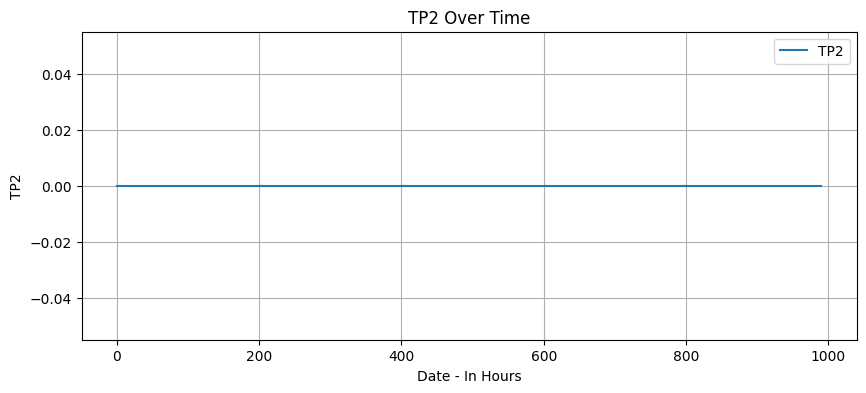

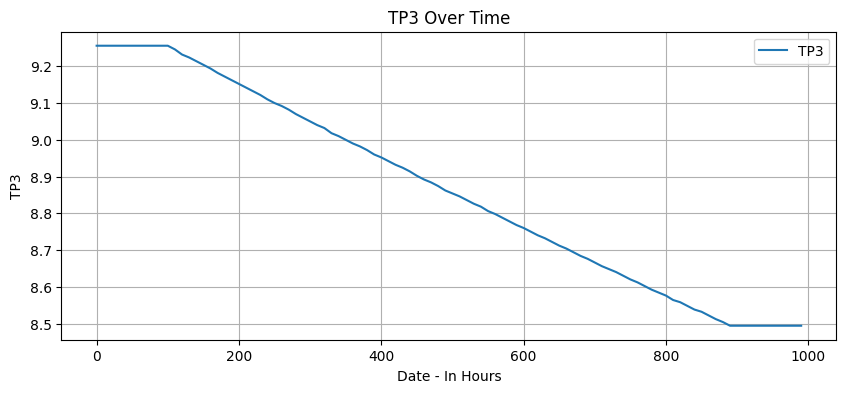

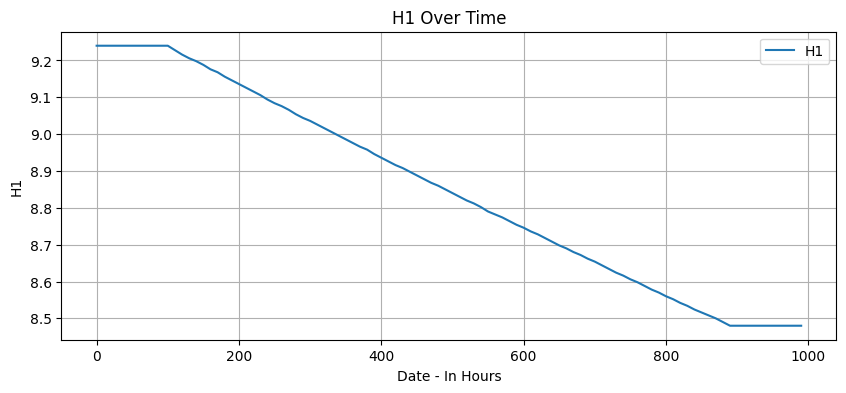

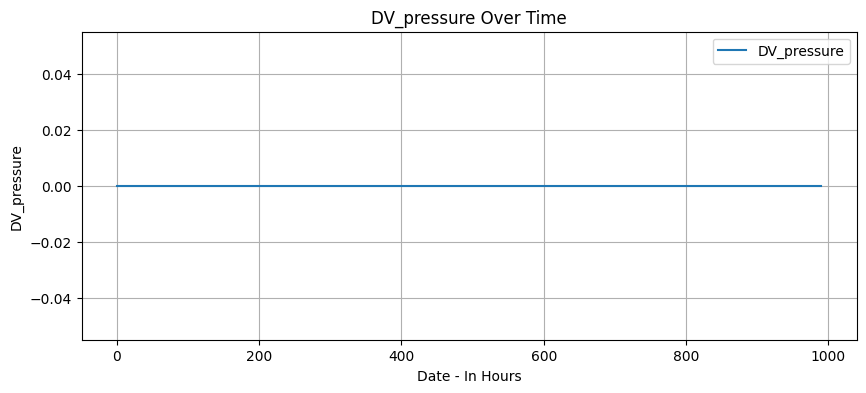

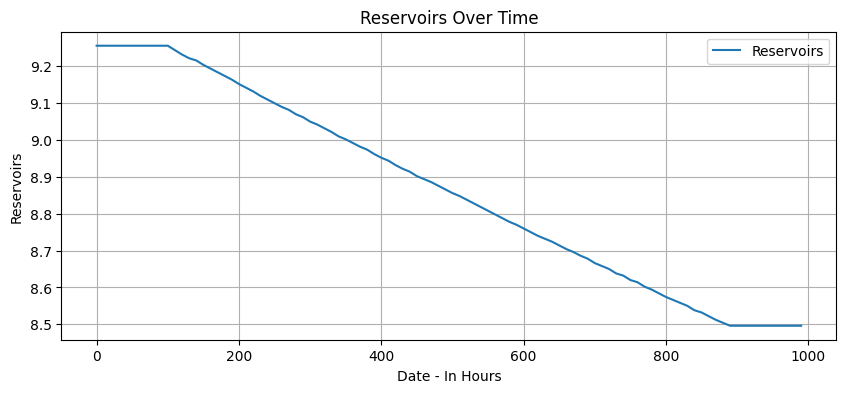

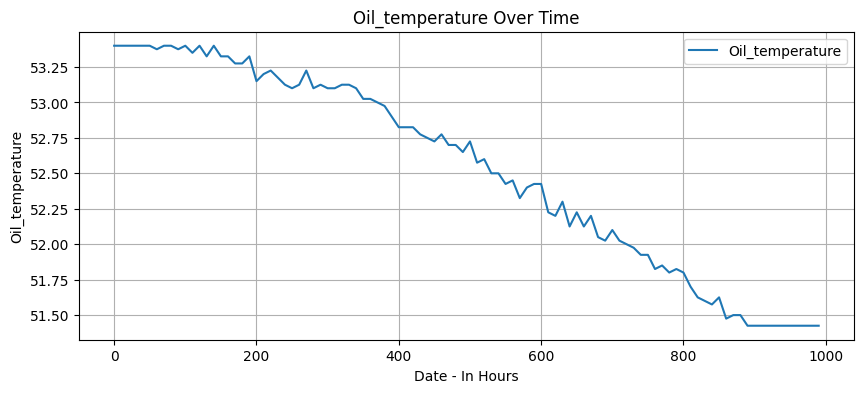

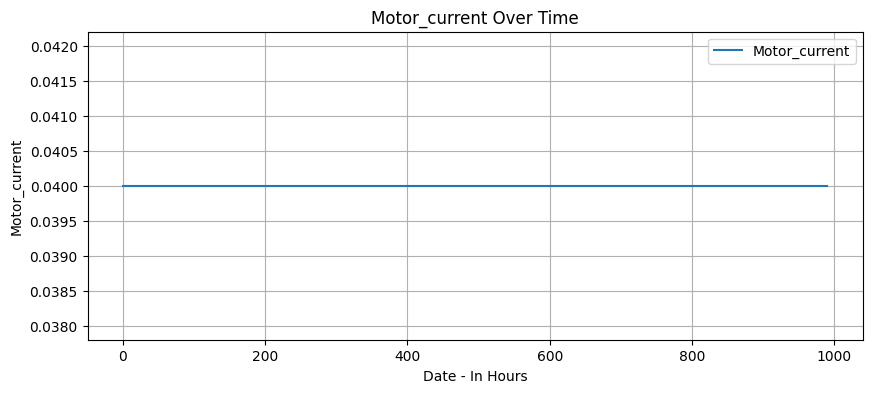

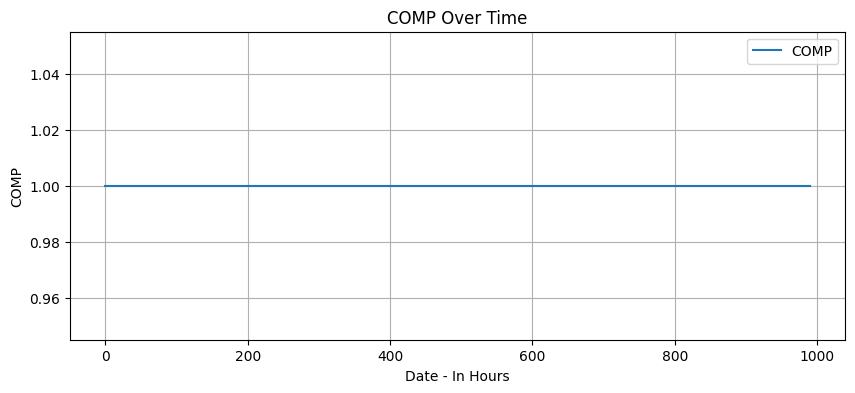

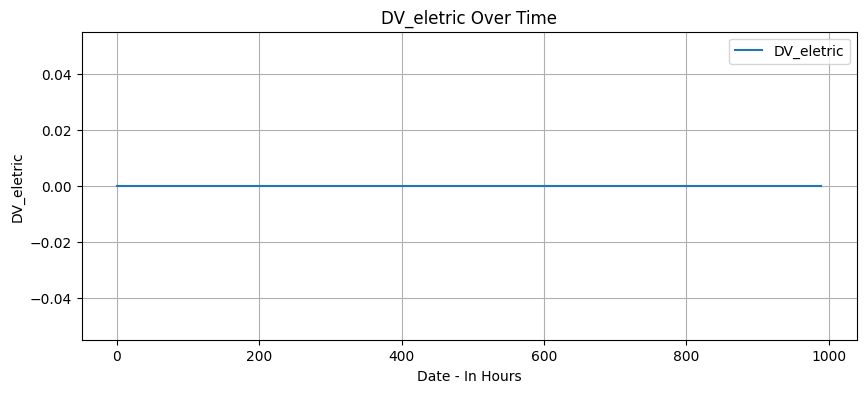

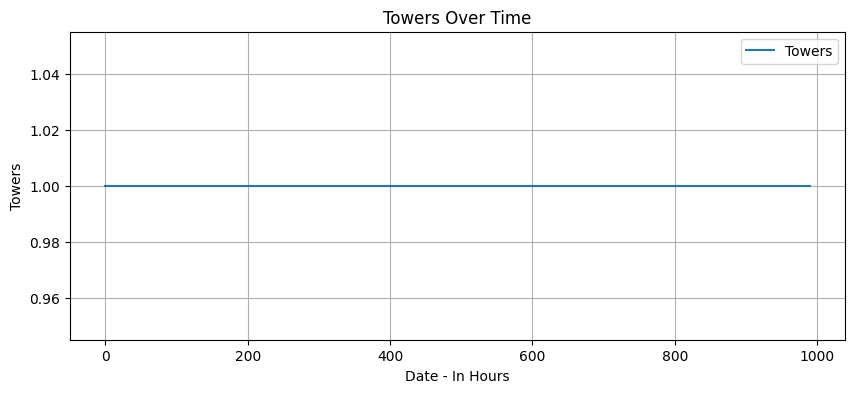

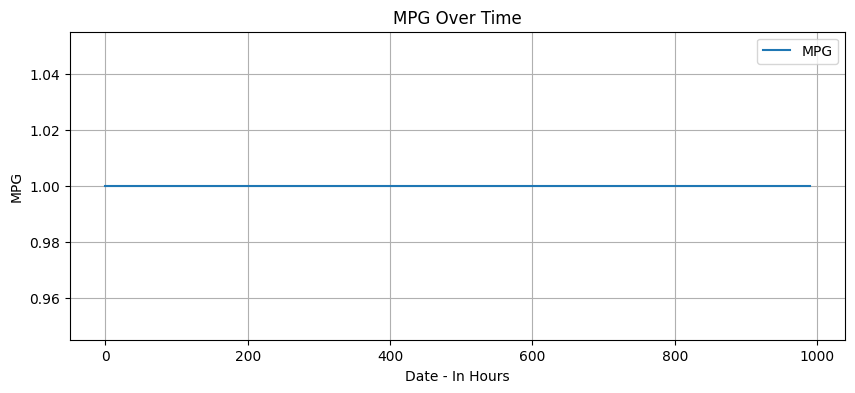

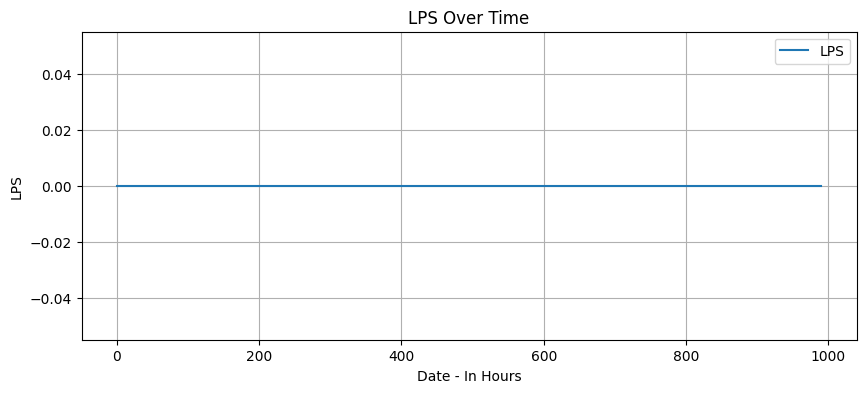

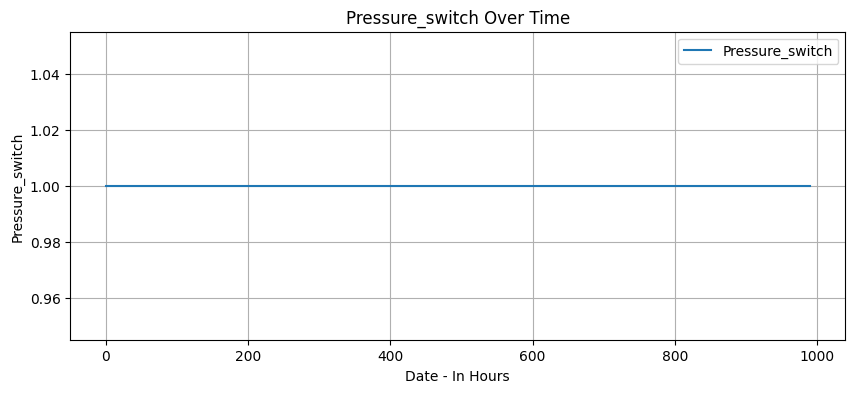

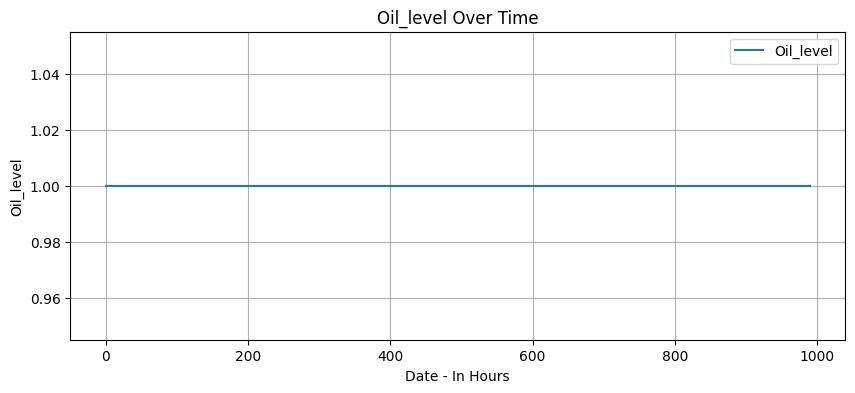

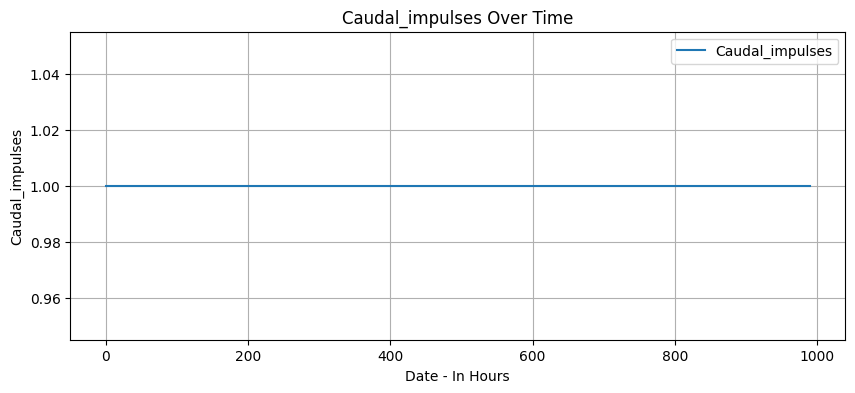

In [9]:
# Set the 'minutes' column as the index
# df.set_index('minutes', inplace=True)

# Create a line chart for each variable
variables = ['TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs',
       'Oil_temperature', 'Motor_current', 'COMP', 'DV_eletric', 'Towers', 'MPG', 'LPS',
       'Pressure_switch', 'Oil_level', 'Caudal_impulses']

for variable in variables:
    plt.figure(figsize=(10, 4))
    plt.plot(df.index, df[variable], marker='', linestyle='-', label=variable)
    plt.title(f'{variable} Over Time')
    plt.xlabel('Date - In Hours')
    plt.ylabel(variable)
    plt.legend()
    plt.grid(True)
    plt.show()

## MODEL TESTING USING THE LAST 100 ROWS OF MY DATA AS MY TESTING DATA

In [12]:
# Load your testing data from a CSV file
metro_test_data = pd.read_csv("testing data.csv", index_col=0)

# Create a DataFrame
tdf = pd.DataFrame(metro_test_data)

# Convert the 'timestamp' column from object (string) to datetime
tdf['timestamp'] = pd.to_datetime(tdf['timestamp'], errors='coerce')

# Calculate the time elapsed in minutes from a reference point
epoch = pd.to_datetime('2020-01-01')
tdf['hours'] = (tdf['timestamp'] - epoch).dt.total_seconds() / 3600

#tdf['timestamp_minutes'] = (tdf['timestamp'] - epoch).dt.total_seconds() / 60

# Round the 'timestamp_minutes' to 2 decimal places
#tdf['timestamp_minutes'] = tdf['timestamp_minutes'].round(2)

# Data processing: Remove unwanted columns
columns_to_remove = ['timestamp']
tdf = tdf.drop(columns=columns_to_remove)

# Use only the last 100 rows for testing your model
tdf = tdf.tail(100)
print(tdf)

FileNotFoundError: ignored

In [ ]:
df = df.iloc[:, :15].copy()
tdf = tdf.iloc[:, :15].copy()

# 1. Data Preprocessing
# Assuming you have DataFrames 'X_train' and 'X_test'
X_train = df # Replace with your actual data
X_test = tdf  # Replace with your actual data

scaler = StandardScaler()
df_scaled = scaler.fit_transform(X_train)
# print(tdf.columns)
# print(df.columns)

# Define labels and colors
labels = {
    'TP2': 'Good to go',
    'TP3': 'To be supervised closely',
    'H1': 'Maintenance needed',
    'DV_pressure': 'Good to go',
    'Reservoirs': 'To be supervised closely',
    'Oil_temperature': 'Good to go',
    'Motor_current': 'To be supervised closely',
    'COMP': 'Active',
    'DV_eletric': 'Active',
    'Towers': 'Active',
    'Pressure_switch': 'Inactive',
    'Oil_level': 'Inactive',
    'Caudal_impulses': 'Maintenance needed',
    'MPG': 'Inactive',
    'LPS': 'Active',
}

colors = {
    'Good to go': 'green',
    'To be supervised closely': 'yellow',
    'Maintenance needed': 'red',
    'Active': 'green',
    'Inactive': 'black'
}

# Filter the labels dictionary to match the columns in X_train
filtered_labels = {col: labels.get(col, 'Unknown') for col in X_train.columns}
y_train = [filtered_labels[col] for col in X_train.columns]

# Debugging: Print shapes and counts
print("Shape of X_train:", df.shape)
print("Shape of X_train_scaled:", df_scaled.shape)
print("Count of labels in y_train:", set(y_train))

Shape of X_train: (100, 15)
Shape of X_train_scaled: (100, 15)
Count of labels in y_train: {'Good to go', 'Active', 'Inactive', 'To be supervised closely', 'Maintenance needed'}


In [ ]:
# 2. Model Training
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# 3. Predictions
predictions = model.predict(X_test_scaled)

# 4. Check each column of the testing data for maintenance needs and visualize the results
for col, prediction in zip(X_test.columns, predictions):
    threshold = 0.8  # Set your threshold value for each feature here

    # Check if maintenance is needed based on the threshold
    maintenance_needed = prediction == 'Maintenance needed'

    # Get the maintenance status label and color
    maintenance_status = labels.get(col, 'Unknown')

    color = colors.get(maintenance_status, 'gray')

    # Print the information and visualize the result with color
    print(f"Column {col} - Maintenance Status: {maintenance_status}, Maintenance Needed: {maintenance_needed}")

    # Visualize maintenance status in color
    plt.bar([col], [1], color=color)
    plt.title(f"Column {col} - Maintenance Status: {maintenance_status}")

plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [100, 15]